# NLP approach to identify Area of Law for Indian Law Judgment

By Chenxin Guo

In [ ]:
import re
import glob
import os
import pandas as pd
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  
import random
from collections import defaultdict
import torch
from pytorch_transformers import BertTokenizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from pytorch_transformers import BertForSequenceClassification, AdamW, BertConfi

In [52]:
# Read the txt into a dataframe with filename and corpus two columns
file_list = glob.glob("./Fixed_Judgements/*.txt")
corpus_dict = {'filename':[], 'corpus':[]}
for file_path in file_list:
    with open(file_path, 'rb') as f_input:
        f = f_input.read().decode('utf-8', errors='ignore')
    f.find('Judgment')
    f = f[f.find('Judgment')+9:]
    f = re.sub(r"\(\w+\)", "", f)
    f = re.sub(r"\(\w+\s+\)", "", f)
    f = re.sub(r"\<\/\w+\>", "", f)
    f = re.sub(r"\<\w+\>", "", f)
    f = re.sub(r"[A-Z]\.", "", f)
    f = re.sub(r"\((i|ii|iii|iv|v|vi|vii|viii|ix|x|xii|ia)\)", "", f)
    f = re.sub(r"\d+", "", f)

    corpus_dict['filename'].append(os.path.basename(file_path).split('.')[0])
    corpus_dict['corpus'].append(f)
corpuse = pd.DataFrame(corpus_dict)
corpuse.set_index('filename', inplace=True)
corpuse.head()

,corpus
filename,
LNIND_1951_CAL_50,"DAS, \n– \n THIS Reference to a has arisen..."
LNIND_1953_CAL_180,"Mookerjee, \n Tile only point which arises fo..."
LNIND_1951_CAL_93,"CHUNDER, \n THIS Rule was obtained by a land..."
LNIND_1993_DEL_165,"\n Bahri, \n TH..."
LNIND_1976_CAL_149,ON an application under Article of the Cons...


In [53]:
# Load mapping csv file and merge with corpus dataframe
df = pd.read_csv("./Interview_Mapping.csv")
df['test'] = df['Area.of.Law'].map(lambda x: x == 'To be Tested')
df.set_index('Judgements', inplace=True)
df = df.merge(corpuse, how='left', left_index=True, right_index=True)

In [54]:
# To feed our text to BERT, it must be split into tokens
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
df['tokens'] = [tokenizer.encode(sent, add_special_tokens = True) for sent in df['corpus']] # Add '[CLS]' and '[SEP]')
df.head()

Token indices sequence length is longer than the specified maximum sequence length for this model (6447 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2799 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (631 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (12649 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1156 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length fo

,Area.of.Law,test,corpus,tokens
Judgements,,,,
LNIND_1988_CAL_114,To be Tested,True,"BHAGABATI PRASAD BANERJEE, \n THIS writ applic...","[101, 1038, 3270, 3654, 14479, 2072, 17476, 25..."
LNIND_1956_CAL_163,To be Tested,True,"Chakravartti, \n(.) This is an appeal from an ...","[101, 15775, 22272, 10755, 6916, 1010, 1006, 1..."
LNIND_1976_CAL_277,To be Tested,True,"BAROOAH, \n THE plaintiff opposite party, Sadh...","[101, 3347, 9541, 4430, 1010, 1996, 20579, 450..."
LNIND_1980_CAL_52,To be Tested,True,"SABYASACHI MUKHARJI, \n(.) These applications,...","[101, 7842, 3762, 16782, 5428, 14163, 22510, 4..."
LNIND_1955_CAL_124,To be Tested,True,"Sinha, \n The petitioner is a circus owner. It...","[101, 8254, 3270, 1010, 1996, 9964, 2121, 2003..."


In [55]:
# Since the maximum length of a token list is 512, therefore for a long text, i will truncate it into several token list 
# with length equals to 512.
# For classification tasks, we must prepend the special [CLS] (101) token to the beginning of every sentence and the special [SEP] (102) token to the end of every sentence.
new_df = {"Judgements":[], "trunc_tokens":[]}

for index, row in df.iterrows():
    NO_101102_token = row['tokens'][1:-1]
    if len(NO_101102_token)>510:
        for k in range(0, (len(NO_101102_token)//510)+1):
            new_df['Judgements'].append(index)
            new_tokens = [101]+ row['tokens'][510*(k):  510*(k+1)]+[102]
            new_df['trunc_tokens'].append(new_tokens)
new_df = pd.DataFrame(new_df).set_index('Judgements')
# now the length is 512 with 101 and 102 at the begining and the end   
new_df = new_df.merge(df, how='left', right_index = True, left_index = True)
new_df.drop(['corpus',  'tokens'], axis = 1,  inplace = True)
print(new_df.shape)
# therefore, for each Judgement name, it is splited into several rows with 512 tokens in each row. therefore, the orginal
# 899 Judgments have been split into 

(8614, 3)


In [56]:
# Label Encoding
labelencoder = LabelEncoder()
new_df['label'] = labelencoder.fit_transform(new_df['Area.of.Law'])
new_df.head()

,trunc_tokens,Area.of.Law,test,label
Judgements,,,,
LNIND_1951_CAL_111,"[101, 101, 20996, 2595, 15496, 1010, 2023, 200...",Civil Procedure,False,6
LNIND_1951_CAL_111,"[101, 2191, 1037, 4431, 2000, 2070, 3025, 5060...",Civil Procedure,False,6
LNIND_1951_CAL_111,"[101, 2025, 2022, 2716, 2065, 1996, 4366, 2001...",Civil Procedure,False,6
LNIND_1951_CAL_111,"[101, 2065, 1996, 8417, 1997, 1996, 3259, 3228...",Civil Procedure,False,6
LNIND_1951_CAL_113,"[101, 101, 25163, 2099, 16963, 1010, 2023, 200...",Company Law,False,7


# Data Exploration

Text(0.5, 1.0, 'Count Plot of Area of Law')

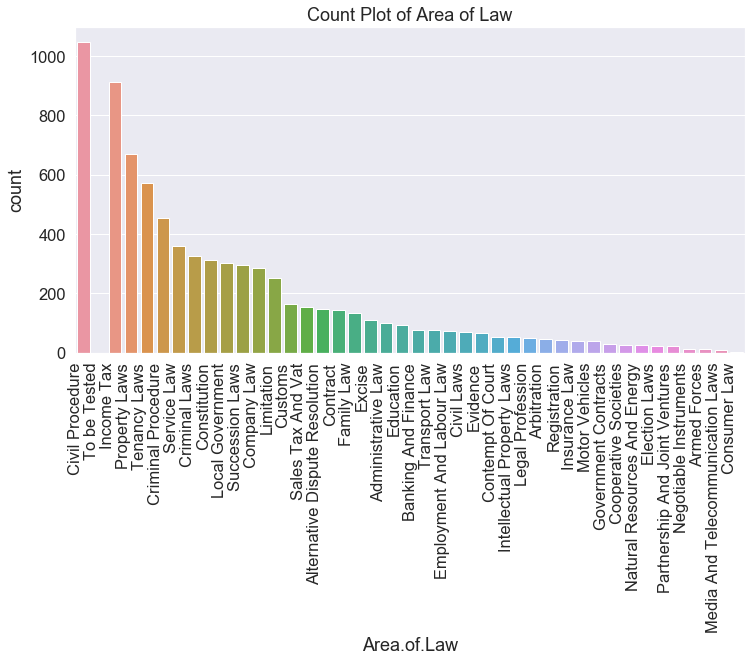

In [219]:
new_df['Area.of.Law'].value_counts()
count_plot = sns.countplot(x="Area.of.Law", data=new_df[new_df['test']==False], 
                           order = new_df['Area.of.Law'].value_counts().index)
#count_plot.set(xlabel='Area of law', ylabel='Count')
cat_plot = count_plot.set_xticklabels(count_plot.get_xticklabels(), rotation=90, ha="right")
count_plot.set_title("Count Plot of Area of Law")

In [57]:
# padding:
# All sentences must be padded or truncated to a single, fixed length. In this case the maximum sentence length is 512 tokens.
# Padding is done with a special [PAD] token, which is at index 0 in the BERT vocabulary. 
input_ids = []
labels = []
for i in range(new_df.shape[0]):
  if new_df.iloc[i]['test'] == False:
    input_ids.append(new_df.iloc[i]['trunc_tokens'])
    labels.append(new_df.iloc[i]['label'])
MAX_LEN = 512
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", value=0, truncating="post", padding="post")

In [58]:
# attention masks:
# The "Attention Mask" is simply an array of 1s and 0s indicating which tokens are padding and which aren't 
attention_masks = []
for sent in input_ids:
    att_mask = [int(token_id > 0) for token_id in sent]
    attention_masks.append(att_mask)

In [59]:
# Training & Validation Split:
# Divide up our training set to use 80% for training and20% for validation.
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, random_state=2018, test_size=0.2)
# Do the same for the masks.
train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels, random_state=2018, test_size=0.2)

In [60]:
# Converting to PyTorch Data Types
# Model expects PyTorch tensors rather than numpy.ndarrays, so convert all of dataset variables.
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [61]:
#Also create an iterator for our dataset using the torch DataLoader class. 
# This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory.
batch_size = 16

# Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

# 4. Train Classification Model

## 4.1. BertForSequenceClassification

In [63]:
    # Tuning the BERT model: I'll be using BertForSequenceClassification. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 42, # The number of output labels
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

## 4.2. Optimizer

In [64]:
# grab the training hyperparameters from within the stored model.
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )


## 4.3. Training Loop

In [65]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [67]:
# Kick off the training
import random
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
# ========================================
#               Training
# =======================================
total_loss = 0
model.train()
for step, batch in enumerate(train_dataloader):
        b_input_ids = batch[0]
        b_input_mask = batch[1]
        b_labels = batch[2]
        model.zero_grad()        
        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        loss = outputs[0]
        total_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

    # Calculate the average loss over the training data.
avg_train_loss = total_loss / len(train_dataloader)            

In [68]:
# ========================================
#               Evaluating
# =======================================
model.eval()

# Tracking variables 
eval_loss, eval_accuracy = 0, 0
nb_eval_steps, nb_eval_examples = 0, 0
accuracy_batch =  []

# Evaluate data for one epoch
for batch in validation_dataloader:
    batch = tuple(t for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch

    # Telling the model not to compute or store gradients, saving memory and
    # speeding up validation
    with torch.no_grad():        
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask)
    # Get the "logits" output by the model. The "logits" are the output
    logits = outputs[0]
    logits = logits.numpy()
    label_ids = b_labels.numpy()

    # Calculate the accuracy for this batch of test sentences.
    tmp_eval_accuracy = flat_accuracy(logits, label_ids)

    # Accumulate the total accuracy.
    eval_accuracy += tmp_eval_accuracy
    accuracy_batch.append(tmp_eval_accuracy)

    # Track the number of batches
    nb_eval_steps += 1

# Report the final accuracy for this validation run.
# this gives you a general average accuracy of this whole evaluation. In reality, a judgment is split into several
# rows with its predicted labe, and we need to figure which label is the most frequent, this is the final label for that judgment
print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))

print("")
print("Training complete!")

  Accuracy: 0.62

Training complete!


Let's take a look at our training loss over all batches:

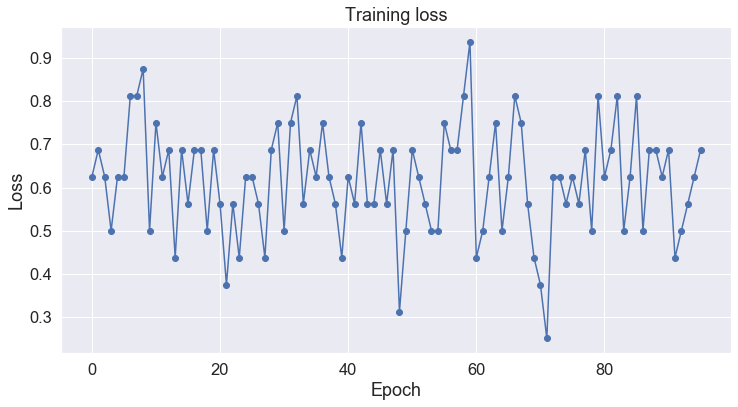

In [71]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(accuracy_batch, 'b-o')

# Label the plot.
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

# 5. Performance On Test Set

### 5.1. Data Preparation



We'll need to apply all of the same steps that we did for the training data to prepare our test data set.

In [107]:
new_df['names'] = new_df.index.get_level_values('Judgements')
# convert string Judgment into numerical index
labelencoder = LabelEncoder()
new_df['segments'] = labelencoder.fit_transform(new_df['names'])

# same as the preprocessing procedure for the training data
input_ids_test = []
labels_test = []
segments_test = []
for i in range(new_df.shape[0]):
    if new_df.iloc[i]['test'] == True:
        input_ids_test.append(new_df.iloc[i]['trunc_tokens'])
        labels_test.append(new_df.iloc[i]['label'])
        segments_test.append(new_df.iloc[i]['segments'])
        
# adding padding:
MAX_LEN = 512
input_ids_test = pad_sequences(input_ids_test, maxlen=MAX_LEN, dtype="long", value=0, truncating="post", padding="post")

# attention masks:
# Create attention masks
attention_masks_test = []
for sent in input_ids_test:
    att_mask_test = [int(token_id > 0) for token_id in sent]
    attention_masks_test.append(att_mask_test)

# Convert to tensors.
prediction_inputs_test = torch.tensor(input_ids_test)
prediction_masks_test = torch.tensor(attention_masks_test)
prediction_labels_test = torch.tensor(labels_test)
prediction_segments_test = torch.tensor(segments_test)

# Set the batch size.  
batch_size = 16

# Create the DataLoader.
prediction_data_test = TensorDataset(prediction_inputs_test, prediction_masks_test, prediction_labels_test, prediction_segments_test)
prediction_sampler_test = SequentialSampler(prediction_data_test)
prediction_dataloader_test = DataLoader(prediction_data_test, sampler=prediction_sampler_test, batch_size=batch_size)

## 5.2. Evaluate on Test Set


In [115]:
# same as the evaluation part
# ========================================
#               Testing
# =======================================
total_label = defaultdict(list)
model.eval()

# Tracking variables 
predictions , true_labels, true_segment = [], [], []

for batch in prediction_dataloader_test:
    batch = tuple(t for t in batch)

    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels, b_segments = batch
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

    logits = outputs[0]
    logits = logits.numpy()
    label_ids = b_labels.numpy()
    segment_ids = b_segments.numpy()
    
    # create a total_label dictionary with key: Judgment IDs and value: the accumulated labels of each chunk for each Judgment ID
    # I need this to get the most frequent label as the final test label for a Judgment, please see the next chunk of code
    for i in range(len(segment_ids)):
        total_label[segment_ids[i]].append(list(np.argmax(logits, axis=1).flatten())[i])


In [134]:
# create a total_label_most_freq dictionary with Judgment as key and max frequent label as value
total_label_most_freq = defaultdict()
def most_frequent(List): 
    return max(set(List), key = List.count)
for key, value in total_label.items():
    total_label_most_freq[key] = most_frequent(value)
    
# convert total_label_most_freq dictionary as a dataframe
most_freq = {'test_segments':[], 'test_label' : []}
for key, value in total_label_most_freq.items():
    most_freq['test_segments'].append(key)
    most_freq['test_label'].append(value)
test_label_dataframe = pd.DataFrame(most_freq)
test_label_dataframe 

# merge the test_label_dataframe with new_df
add_test_label = new_df.merge(test_label_dataframe, how = 'left', left_on = 'segments', right_on = 'test_segments')

In [221]:
add_test_label.head()

,trunc_tokens,Area.of.Law,test,label,segments,names,test_segments,test_label
0,"[101, 101, 20996, 2595, 15496, 1010, 2023, 200...",Civil Procedure,False,6,0,LNIND_1951_CAL_111,NaN,NaN
1,"[101, 2191, 1037, 4431, 2000, 2070, 3025, 5060...",Civil Procedure,False,6,0,LNIND_1951_CAL_111,NaN,NaN
2,"[101, 2025, 2022, 2716, 2065, 1996, 4366, 2001...",Civil Procedure,False,6,0,LNIND_1951_CAL_111,NaN,NaN
3,"[101, 2065, 1996, 8417, 1997, 1996, 3259, 3228...",Civil Procedure,False,6,0,LNIND_1951_CAL_111,NaN,NaN
4,"[101, 101, 25163, 2099, 16963, 1010, 2023, 200...",Company Law,False,7,1,LNIND_1951_CAL_113,NaN,NaN


In [202]:
# convert the Judgment IDs into original name and replace the label IDs into original 'area of law'
# and finally print the result as a dataframe.

law_name = add_test_label[['Area.of.Law', 'label']].drop_duplicates()
area_of_law_dict = defaultdict()
for i in range(law_name.shape[0]):
    area_of_law_dict[law_name.iloc[i]['label']]  = law_name.iloc[i]['Area.of.Law']
    
test_result = add_test_label[add_test_label['test']==True][['names', 'test_label']]
test_result.drop_duplicates(inplace=True)

test_result_dict = defaultdict()
for i in range(test_result.shape[0]):
    test_result_dict[test_result.iloc[i]['names']]  = test_result.iloc[i]['test_label']

test_area_of_law = defaultdict()
for key, value in test_result_dict.items():
    test_area_of_law[key] = area_of_law_dict[int(value)]

# convert into dataframe and export into csv file
final = {'name':[], 'law':[]}
for key, value in test_area_of_law.items():
    final['name'].append(key)
    final['law'].append(value)
final =  pd.DataFrame(final)


final.to_csv(r'./results.csv')
final

,name,law
0,LNIND_1951_CAL_195,Tenancy Laws
1,LNIND_1951_CAL_2,Income Tax
2,LNIND_1951_CAL_255,Sales Tax And Vat
3,LNIND_1951_CAL_257,Criminal Procedure
4,LNIND_1951_CAL_60,Civil Procedure
...,...,...
95,LNIND_1993_DEL_164,Tenancy Laws
96,LNIND_1993_DEL_167,Civil Procedure
97,LNIND_1993_DEL_172,Service Law
98,LNIND_1993_DEL_177,Tenancy Laws


# Appendix


## A1. Saving & Loading Fine-Tuned Model

In [80]:
import os

output_dir = './law'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

model_to_save = model.module if hasattr(model, 'module') else model
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)


Saving model to /Users/guochenxin/Desktop/law


('/Users/guochenxin/Desktop/law/vocab.txt',
 '/Users/guochenxin/Desktop/law/special_tokens_map.json',
 '/Users/guochenxin/Desktop/law/added_tokens.json')